# Advances in Machine Learning with Big Data

### (part 1 of 2) 
### Trinity 2020 Weeks 1 - 4
### Dr Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

## 3. Data abundance and 'jaggedness' -> regularization and the problem of overfit

## 4. Regularization through resampling methods (bootstrap etc.)

## Contents Weeks 1-4:

1. Introducing this course's dataset

1. Being an econometrician _and_ a data scientist

1. **Data abundance and 'jaggedness' -> regularization and the problem of overfit**

1. **Regularization through resampling methods (bootstrap etc.)**

1. Regularization through predictor/feature selection (Lasso etc.)

1. Moving from linear regression to the perceptron

1. Moving from linear regression to the random forest (and similar)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
UCI_LIB = os.path.join(REPO_DIR, 'lib')
sys.path.append(UCI_LIB)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np  
import pandas as pd  

In [3]:
#  pull in scikit-learn libraries:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold

In [4]:
import sbs_sklearn    # module where I've put some functions from the last class

### We return to our

### > dataset

### > prediction problem

### > & linear model

**Q.: given the time, date, and complexity of an invoice, what's its expected spend per item shipped?**

In [5]:
# the data:
df, invalids, invoices = sbs_sklearn.get_standard_data()

2020-04-15 11:23:10,112 INFO:Loading C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2020-04-15 11:23:14,683 INFO:Loaded C:\Users\jerem\Documents\work\Oxford\SBS\MLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


In [6]:
#  We build some additional columns in our dataframe to take logs etc.:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

In [7]:
predictors = ['log_n_codes', 'hour', 'month', 'words_per_item']

In [8]:
# set out `y` and `X` variables:
y = invoices.log_item_spend
X = invoices[predictors] 

In [9]:
model = linear_model.LinearRegression()

2020-04-15 11:29:49,424 INFO:In study 1/50, train on 20165 points; then test on the other 412; first few test points = [  9  54 108 109 111 128 137 273 296 370] 


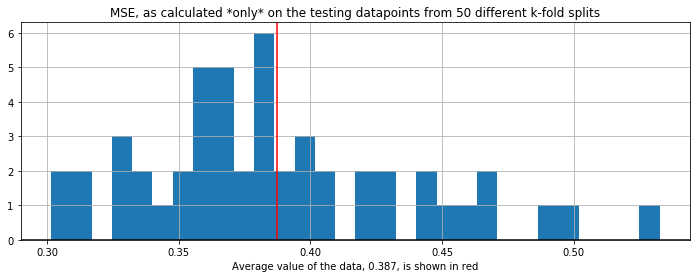

In [19]:
scores = sbs_sklearn.train_n_test(X, y, 50, metric=metrics.mean_squared_error)
sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

OK, now lets stress-test the linear model:

2020-04-15 14:39:54,329 INFO:In study 1/50, train on 412 points; then test on the other 20165; first few test points = [0 1 2 3 4 5 6 7 8 9] 


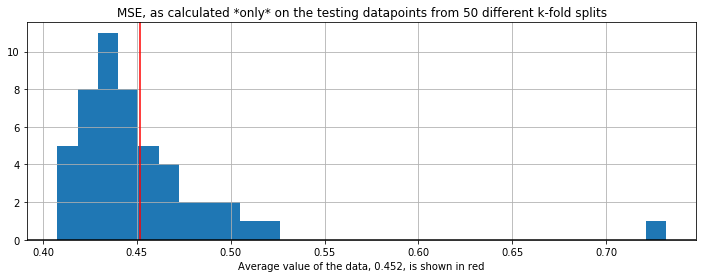

In [29]:
scores = sbs_sklearn.train_n_test(X, y, 50, metric=metrics.mean_squared_error, 
                                  train_on_minority=True)   #<< invoking this option
sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

#### Comments:

* our linear model that can be fit successfully on a rather small proportion of our dataset

* I would say this is because it is fairly simple and concise

* but this simplicity is tantalising: 

     * could we replace the model with a more complicated one, to get a better MSE?


* *Introduction to Statistical Learning* Chapter 3

In [12]:
order = 3

In [13]:
data = invoices.copy()
higher_order_preds = predictors.copy()

for o in range(order - 1):
    for p1 in higher_order_preds:
        for p2 in higher_order_preds:
            data[f'{p1}_{p2}'] = data[p1] * data[p2]
    higher_order_preds.extend([f'{p1}_{p2}' for p1 in higher_order_preds for p2 in higher_order_preds])

In [14]:
len(higher_order_preds)

420

In [15]:
X = data[higher_order_preds]

2020-04-15 11:47:25,474 INFO:In study 1/50, train on 20165 points; then test on the other 412; first few test points = [  2  18  68 140 143 265 310 320 345 355] 


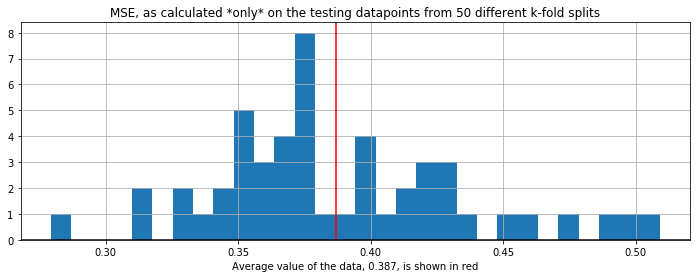

In [21]:
scores = sbs_sklearn.train_n_test(X, y, 50, metric=metrics.mean_squared_error)
sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)

2020-04-15 11:47:54,595 INFO:In study 1/50, train on 412 points; then test on the other 20165; first few test points = [0 1 2 3 4 5 6 7 8 9] 


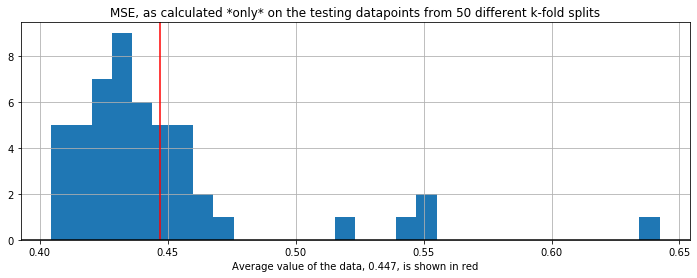

In [22]:
scores = sbs_sklearn.train_n_test(X, y, 50, metric=metrics.mean_squared_error, train_on_minority=True)
sbs_sklearn.mfe_r2_diag(scores, metric_name='MSE', histogram=True)